<a href="https://colab.research.google.com/github/ganesh3/pytorch-work/blob/master/VariationalAutoEncoder_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Device configuration
# Check if a GPU is available and use it, otherwise use CPU

In [ ]:
device

device(type='cpu')

# Image dimensions and channels

In [ ]:
IMG_SIZE=28
N_CHANNELS =1

# Data preprocessing
# Define transformations applied to image data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load FashionMNIST dataset
# Download if not present locally

In [ ]:
train_dataset = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='.', train=False, download=True, transform=transform)

In [ ]:
batch_size = 128

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Plot some images
def im_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Display a sample batch of images

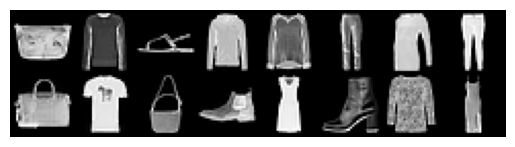

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
im_show(make_grid(images[:16]))

## Encoder

**Purpose:** The encoder's primary function is to take an input image and transform it into a lower-dimensional latent representation, capturing the essential features of the image. It essentially compresses the information content of the image into a more compact form.

**Structure:**

1. **Input:** The encoder takes an image as input, typically represented as a tensor.
2. **Convolutional Layers (Optional):** In some VAE architectures, the encoder may start with convolutional layers to extract spatial features from the image. However, in your code, it directly flattens the input.
3. **Fully Connected Layers:** The flattened input or the output of convolutional layers is then passed through one or more fully connected layers. These layers perform linear transformations on the data, reducing its dimensionality.
4. **Output:** The final layer of the encoder produces two outputs:
    - **`mean`:** A vector representing the mean of the latent distribution.
    - **`logvar`:** A vector representing the logarithm of the variance of the latent distribution.
    These two outputs define the parameters of a Gaussian distribution in the latent space.

**Functionality:**

1. **Feature Extraction:** The encoder's layers extract relevant features from the input image, progressively reducing the dimensionality of the data.
2. **Latent Distribution:** The final layer outputs the `mean` and `logvar`, which define a Gaussian distribution in the latent space. This distribution represents the encoded information of the input image.
3. **Sampling:** The `reparameterise` function uses the `mean` and `logvar` to

## Understanding Key Concepts in the VAE

### Reparameterization Trick

The reparameterization trick is a crucial technique in VAEs that allows us to backpropagate gradients through the sampling process, which is normally non-differentiable. Here's how it works:

1. **Latent Space Sampling:** In a VAE, we want to sample from a distribution in the latent space (often a Gaussian) to generate new data. Direct sampling is not differentiable.

2. **Reparameterization:** Instead of direct sampling, we reparameterize the sampling process. We sample from a standard normal distribution (epsilon) and then transform it using the learned mean (mu) and standard deviation (sigma) of the latent distribution.

3. **Differentiability:** This transformation makes the sampling process differentiable because we're now backpropagating through the parameters (mu and sigma) rather than the random sampling itself.

This trick is essential for training VAEs effectively, as it enables us to optimize the model's parameters using gradient-based methods.

### Sampling from the Latent Space

The statement "In a VAE, we want to sample from a distribution in the latent space (often a Gaussian) to generate new data" highlights a fundamental aspect of VAEs. The latent space is a lower-dimensional representation of the input data, and by sampling from a distribution in this space, we can generate new, similar data points.

The Gaussian distribution is often chosen for the latent space because it's a well-understood and flexible distribution that can model a wide range of data.

### Why `nn.Linear` for Mean and Logvar?

The `mean` and `logvar` are represented using `nn.Linear` layers in the encoder because these layers are capable of learning the parameters of the latent distribution.

- **`nn.Linear` as Function Approximators:** Linear layers are essentially function approximators that can learn complex relationships between inputs and outputs. In this case, they learn the mapping from the input data to the parameters of the latent distribution (mean and logvar).
- **Flexibility and Efficiency:** Linear layers are relatively simple and efficient to compute, making them a suitable choice for this task.
- **Integration with Neural Networks:** `nn.Linear` layers are seamlessly integrated with the rest of the neural network architecture, allowing for end-to-end training of the VAE.

By using `nn.Linear` layers, the VAE can effectively learn the parameters of the latent distribution, enabling it to generate diverse and realistic new samples.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_dim, in_channels, encoding_dim, device):
    super().__init__()
    self.encoding_dim = encoding_dim
    self.device = device
    self.in_dim = in_dim
    self.in_channels = in_channels
    self.fc_dim = 512
    self.flatten_dim = self.in_channels * self.in_dim**2
    self.fc1 = nn.Linear(self.flatten_dim, self.fc_dim).to(device)
    self.relu = nn.ReLU().to(self.device)
    self.mean = nn.Linear(self.fc_dim, self.encoding_dim).to(device)
    # outputs the log of the variance
    self.var = nn.Linear(self.fc_dim, self.encoding_dim).to(device)

    # Initialize weights
    self.initialise_weights()
    self.to(device)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.relu(self.fc1(x))
    mean = self.mean(x)
    logvar = self.var(x)
    return mean, logvar

  def reparameterise(self, mean, logvar):
    mean = mean.to(self.device)
    logvar = logvar.to(self.device)
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std).to(self.device)
    return mean + epsilon * std

  def initialise_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        # Xavier initialization for weights
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          # Initialize biases to zero
          nn.init.zeros_(m.bias)

In [ ]:
vae_encoder_test = Encoder(in_dim=IMG_SIZE, in_channels=N_CHANNELS, encoding_dim=128, device=device)
vae_encoder_test = vae_encoder_test.to(device)
vae_encoder_test

Encoder(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (mean): Linear(in_features=512, out_features=128, bias=True)
  (var): Linear(in_features=512, out_features=128, bias=True)
)

In [ ]:
random_img = torch.randn(size=(33, N_CHANNELS, IMG_SIZE, IMG_SIZE)).to(device)

In [ ]:
# Check device of model parameters
for name, param in vae_encoder_test.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

# Check device of input tensor
print(random_img.device)

print(f"First parameter device: {next(vae_encoder_test.parameters()).device}")

Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter mean.weight is on device: cpu
Parameter mean.bias is on device: cpu
Parameter var.weight is on device: cpu
Parameter var.bias is on device: cpu
cpu
First parameter device: cpu


In [ ]:
mu, logvar =  vae_encoder_test(random_img)

In [ ]:
# First, check what vae_encoder_test actually is
print(type(vae_encoder_test))

<class '__main__.Encoder'>


In [ ]:
out = vae_encoder_test.reparameterise(mu, logvar)

In [ ]:
out.shape

torch.Size([33, 128])

In [ ]:
def visualize_encoder_output(encoder, input_data, device):
    # Get encoder output
    encoder.eval()  # Set to evaluation mode
    with torch.no_grad():
        mean, logvar = encoder(input_data.to(device))

    # Convert to numpy for visualization
    mean_np = mean.cpu().numpy()
    logvar_np = logvar.cpu().numpy()  # This is log variance
    var_np = np.exp(logvar_np)  # This is actual variance

    print("\nMean Statistics:")
    print(f"Shape: {mean_np.shape}")
    print(f"Mean range: [{mean_np.min():.3f}, {mean_np.max():.3f}]")
    print(f"Average activation: {mean_np.mean():.3f}")

    print("\nLog Variance Statistics:")
    print(f"Shape: {logvar_np.shape}")
    print(f"Log variance range: [{logvar_np.min():.3f}, {logvar_np.max():.3f}]")
    print(f"Average log variance: {logvar_np.mean():.3f}")

    print("\nActual Variance Statistics (exp(log_var)):")
    print(f"Variance range: [{var_np.min():.3f}, {var_np.max():.3f}]")
    print(f"Average variance: {var_np.mean():.3f}")

    return mean_np, logvar_np, var_np

def plot_distributions(mean_np, logvar_np, var_np):
    plt.figure(figsize=(15, 5))

    # Plot mean distribution
    plt.subplot(1, 3, 1)
    plt.hist(mean_np.flatten(), bins=50)
    plt.title('Distribution of Means')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')

    # Plot log variance distribution
    plt.subplot(1, 3, 2)
    plt.hist(logvar_np.flatten(), bins=50)
    plt.title('Distribution of Log Variances')
    plt.xlabel('Log Variance Value')
    plt.ylabel('Frequency')

    # Plot actual variance distribution
    plt.subplot(1, 3, 3)
    plt.hist(var_np.flatten(), bins=50)
    plt.title('Distribution of Variances (exp(log_var))')
    plt.xlabel('Variance Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## Encoder Output Visualization and Analysis

The following code snippet visualizes the output of the encoder when given a random image as input:


Mean Statistics:
Shape: (33, 128)
Mean range: [-3.432, 3.228]
Average activation: -0.021

Log Variance Statistics:
Shape: (33, 128)
Log variance range: [-4.409, 3.641]
Average log variance: -0.007

Actual Variance Statistics (exp(log_var)):
Variance range: [0.012, 38.114]
Average variance: 1.646


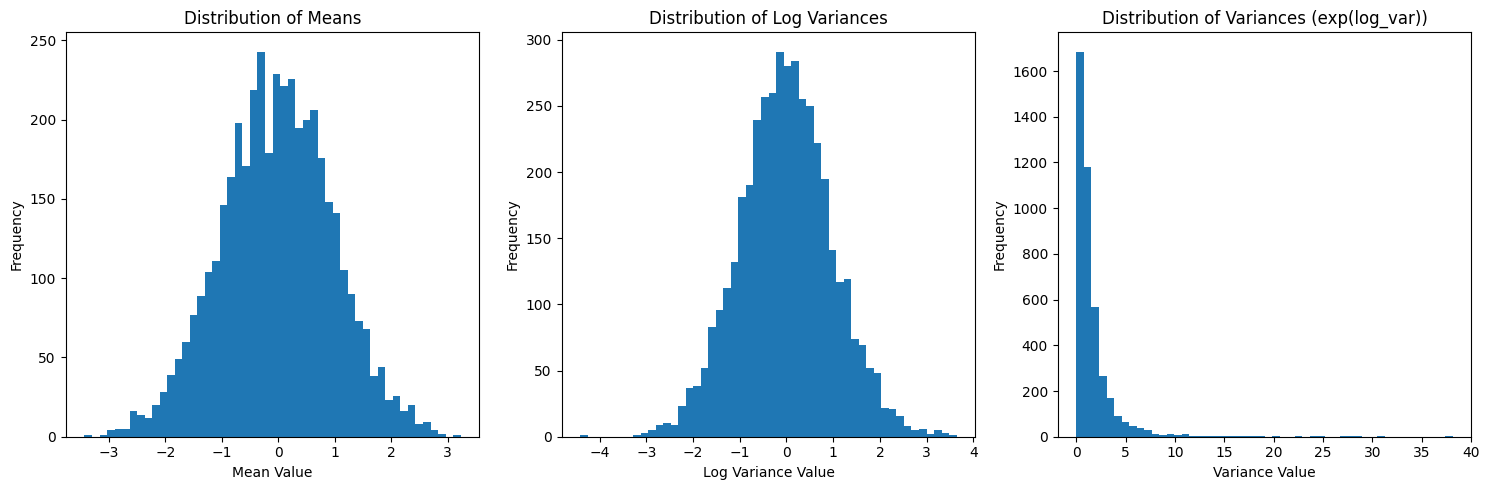

In [ ]:
mean_np, logvar_np, var_np = visualize_encoder_output(vae_encoder_test, random_img, device)
plot_distributions(mean_np, logvar_np, var_np)

## Decoder

**Purpose:** The decoder's role is to take the latent representation generated by the encoder and reconstruct the original input image. It essentially decompresses the information encoded in the latent space to generate an image similar to the input.

**Structure:**

1. **Input:** The decoder takes the latent representation `z` as input.
2. **Fully Connected Layers:** The latent representation is passed through one or more fully connected layers. These layers gradually increase the dimensionality of the data, transforming it back towards the original image dimensions.
3. **Reshaping:** If necessary, the output of the fully connected layers is reshaped to match the dimensions of the original image.
4. **Output:** The final layer of the decoder produces an output tensor that represents the reconstructed image.

**Functionality:**

1. **Latent Space Mapping:** The decoder takes the latent representation `z` and maps it back to the original data space.
2. **Reconstruction:** The decoder's layers progressively transform the latent representation, increasing its dimensionality and reconstructing the features of the original image.
3. **Output Generation:** The final layer generates an output that resembles the original input image.

**Role in VAE:**

- The decoder is responsible for reconstructing the input data from the latent representation generated by the encoder.
- It plays a crucial role in the VAE's training process, as the reconstruction loss is used to guide the learning of both the encoder and decoder.
- The decoder's ability to accurately reconstruct images from the latent space is a key indicator of the VAE's performance.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, out_dim, out_channel, encoding_dim, device):
    super().__init__()
    self.out_dim = out_dim
    self.out_channel = out_channel
    self.encoding_dim = encoding_dim
    self.device = device
    self.fc_dim = 512

    self.reshape_dim = self.out_channel * self.out_dim**2
    self.fc1 =  nn.Linear(self.encoding_dim, self.fc_dim).to(device)
    self.relu = nn.ReLU().to(device)
    self.fc2 = nn.Linear(self.fc_dim, self.reshape_dim).to(device)

  def forward(self, z):
    z = self.relu(self.fc1(z))
    y = torch.sigmoid(self.fc2(z))
    return y.reshape((-1, self.out_channel, self.out_dim, self.out_dim))

In [ ]:
vae_decoder_test = Decoder(out_dim=IMG_SIZE, out_channel=N_CHANNELS, encoding_dim=128, device=device)
vae_decoder_test = vae_decoder_test.to(device)
vae_decoder_test

Decoder(
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
final_out = vae_decoder_test(out)
final_out.shape

torch.Size([33, 1, 28, 28])

In [ ]:
class VAE(nn.Module):
  def __init__(self, dim, n_channels, encoding_dim, device):
    super().__init__()
    self.dim = dim
    self.n_channels = n_channels
    self.encoding_dim = encoding_dim
    self.device = device

    self.encoder = Encoder(in_dim=self.dim, in_channels=self.n_channels, encoding_dim=self.encoding_dim, device=self.device)
    self.decoder = Decoder(out_dim=self.dim, out_channel=self.n_channels, encoding_dim=self.encoding_dim, device=self.device)

    self.mean = 0
    self.logvar = 0

  def forward(self, x):
    self.mean, self.logvar = self.encoder(x)
    z = self.encoder.reparameterise(self.mean, self.logvar)
    y = self.decoder(z)
    return y

In [ ]:
vae_test = VAE(dim=IMG_SIZE, n_channels=N_CHANNELS, encoding_dim=128, device=device)
vae_test = vae_test.to(device)
vae_test

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (relu): ReLU()
    (mean): Linear(in_features=512, out_features=128, bias=True)
    (var): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=512, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
output = vae_test(random_img)
output.shape

torch.Size([33, 1, 28, 28])

In [ ]:
IN_DIM = IMG_SIZE
ENCODING_DIM = 2
vae = VAE(dim=IN_DIM, n_channels=N_CHANNELS, encoding_dim=ENCODING_DIM, device=device)
vae = vae.to(device)

In [ ]:
def vae_loss(input, reconstruction, mu, logvar):
  reconstruction_loss = ((input - reconstruction)**2).mean()

  kl_loss = -0.5 * torch.sum(1 + logvar - torch.exp(logvar) - mu**2, axis = 1)
  mean_kl_loss = torch.mean(kl_loss)/(N_CHANNELS * IMG_SIZE**2)
  return reconstruction_loss + mean_kl_loss

In [ ]:
criterion = vae_loss
optimiser = torch.optim.AdamW(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.9)

In [ ]:
def visualise_samples(model, test_loader, num_samples, skip=1):
    """
    Visualize original images and their reconstructions from the model.

    Args:
        model: The VAE model
        test_loader: DataLoader containing test images
        num_samples: Number of samples to visualize
        skip: Number of batches to skip before visualization
    """
    # Get samples from the loader more efficiently
    for _ in range(skip):
        images, _ = next(iter(test_loader))

    # Process images through model
    model.eval()
    with torch.no_grad():
        output = model(images.to(device))

        # Process only the required number of samples
        images = (images[:num_samples]
                 .cpu()  # Move to CPU first
                 .permute(0, 2, 3, 1)
                 .numpy())

        output = (output[:num_samples]
                 .cpu()
                 .permute(0, 2, 3, 1)
                 .numpy())

    # Create figure once
    fig, axes = plt.subplots(
        nrows=2,
        ncols=num_samples,
        figsize=(2.5*num_samples, 4),
        sharex=True,
        sharey=True
    )

    # Plot images more efficiently
    for idx, (title, batch) in enumerate([('Original', images),
                                        ('Reconstruction', output)]):
        for i in range(num_samples):
            ax = axes[idx, i]
            ax.imshow(batch[i], cmap='gray')
            ax.axis('off')

            # Only set ylabel for first column
            if i == 0:
                ax.set_ylabel(title)

    plt.tight_layout()
    plt.show()
    plt.close()

    return fig

In [ ]:
def train_step(model, train_loader, optimiser, criterion):
  model.train()
  epoch_loss = []

  for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
    images, label = batch
    images = images.to(device, non_blocking=True)
    label = label.to(device, non_blocking=True)

    optimiser.zero_grad()
    reconstruction = model(images)
    loss = criterion(images, reconstruction, model.mean, model.logvar)
    epoch_loss.append(loss.item())

    loss.backward()
    optimiser.step()

  return np.mean(epoch_loss)

In [ ]:
def test_step(model, test_loader, criterion):
  model.eval()
  epoch_loss = []

  for i, batch in tqdm(enumerate(test_loader), total=len(test_loader), leave=False):
    images, label = batch
    images = images.to(device, non_blocking=True)
    label = label.to(device, non_blocking=True)

    reconstruction = model(images)
    loss = criterion(images, reconstruction, model.mean, model.logvar)
    epoch_loss.append(loss.item())

  return np.mean(epoch_loss)

In [ ]:
EPOCHS = 25
losses = {"train_loss": [], "test_loss": []}
epochs = []

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1/25, Train Loss: 0.0355, Test Loss: 0.0357


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2/25, Train Loss: 0.0355, Test Loss: 0.0357


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3/25, Train Loss: 0.0355, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4/25, Train Loss: 0.0355, Test Loss: 0.0357


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5/25, Train Loss: 0.0355, Test Loss: 0.0357


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8/25, Train Loss: 0.0354, Test Loss: 0.0357


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

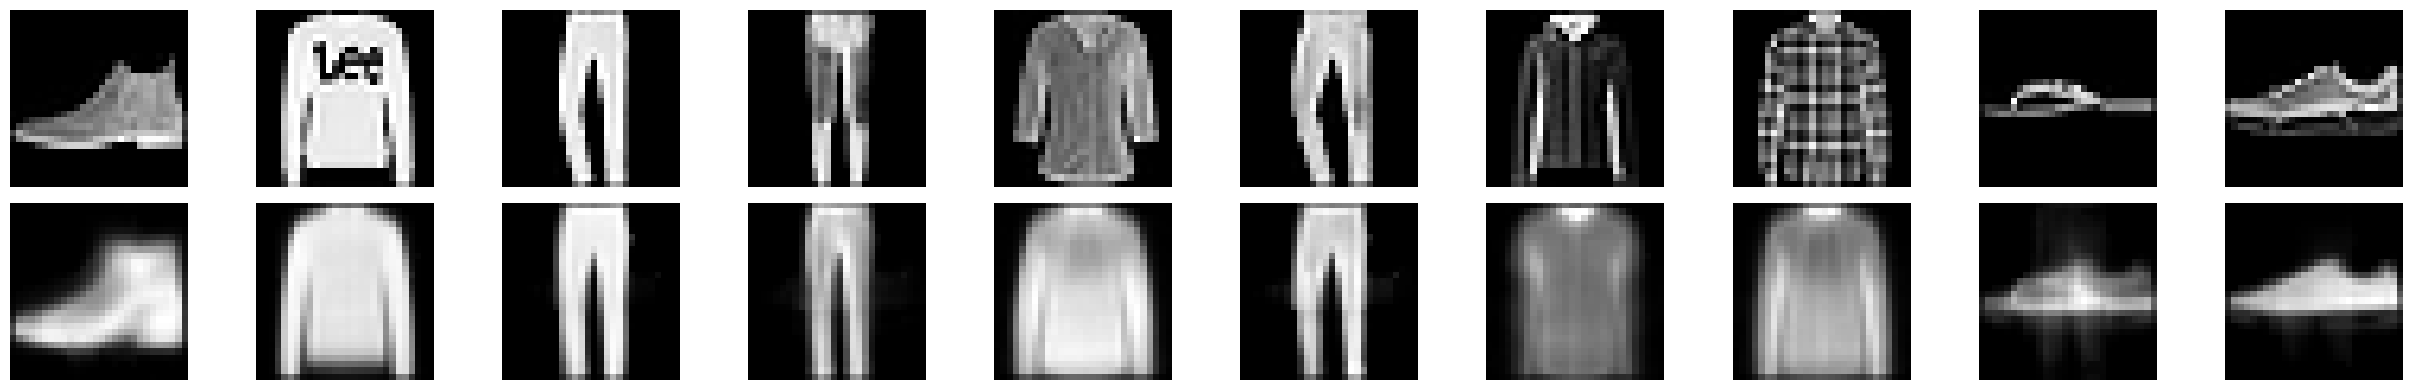

Epoch: 10/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17/25, Train Loss: 0.0354, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

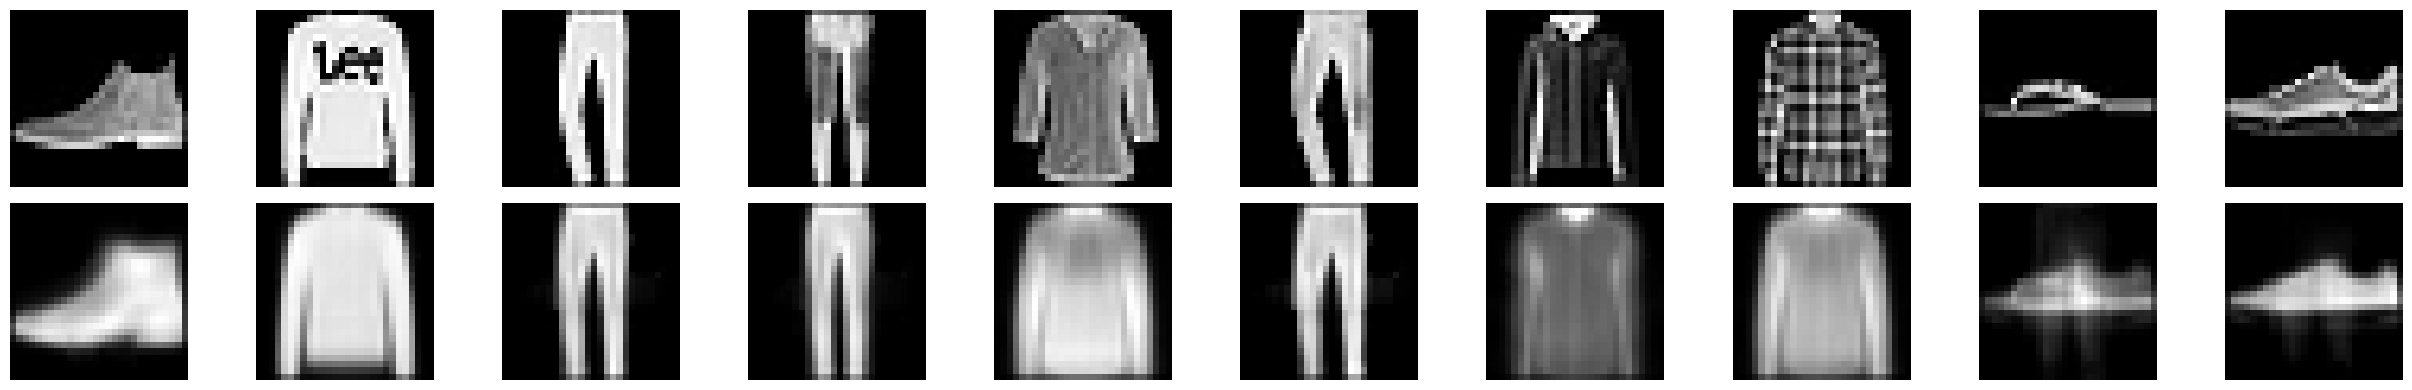

Epoch: 20/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24/25, Train Loss: 0.0353, Test Loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25/25, Train Loss: 0.0353, Test Loss: 0.0356


In [ ]:
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
  train_loss = train_step(vae, trainloader, optimiser, criterion)
  test_loss = test_step(vae, testloader, criterion)
  if (epoch + 1) % 10 == 0:
    visualise_samples(vae, testloader, 10)

  scheduler.step()
  losses["train_loss"].append(train_loss)
  losses["test_loss"].append(test_loss)
  epochs.append(epoch)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

In [ ]:
# Plot loss
plt.figure(figsize=(8,8))
plt.plot(epochs, losses["train_loss"], label="train")
plt.plot(epochs, losses["test_loss"], label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.title("Loss vs Epochs");

In [ ]:
# Visualize reconstructions
# obtain one batch of test images
visualise_samples(vae, testloader, 10, skip=10)

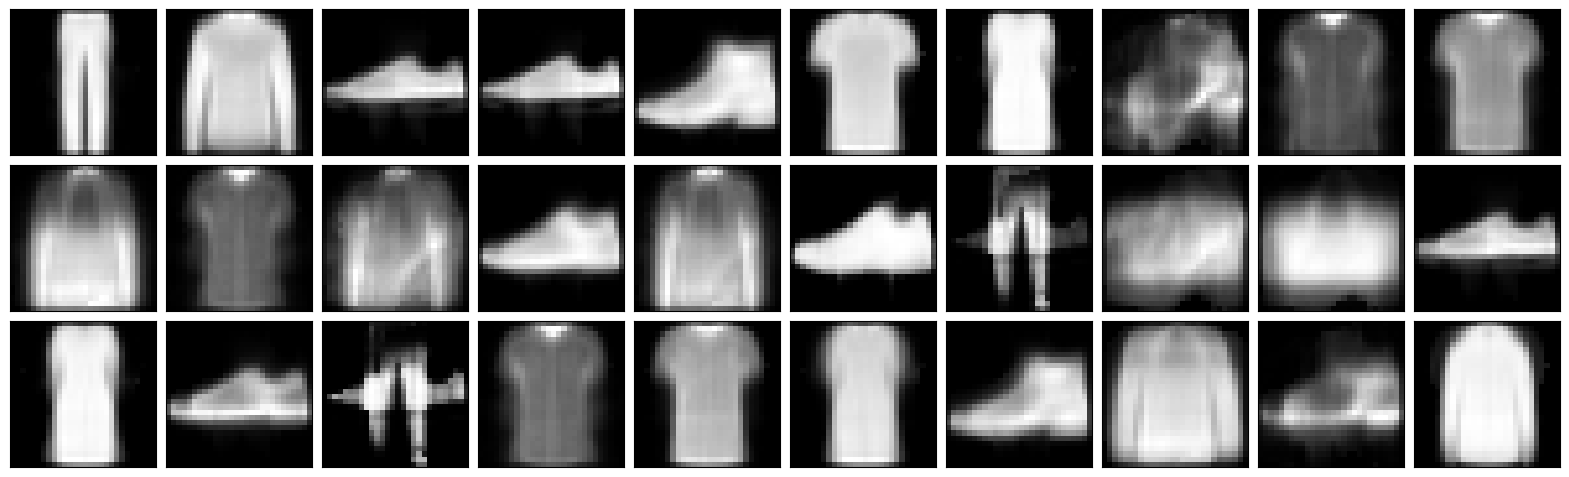

In [ ]:
# Generate new samples
N_EXAMPLES = 30
z = torch.randn(N_EXAMPLES, ENCODING_DIM)
z = z.to(device)
with torch.no_grad():
  generated_samples = vae.decoder(z)

generated_samples = generated_samples.detach().cpu().permute(0, 2, 3, 1).numpy()

# plot generated samples
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(N_EXAMPLES // 10, 10),
                 axes_pad=0.1,  # pad between axes
                 )
for ax, im in zip(grid, generated_samples):
    ax.imshow(im, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()